In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
conn2 = pyodbc.connect('DRIVER={SQL Server};'
                                'Server=finesxxx.xxxx.xxxxxxx.amazonaws.com,xxxx;'
                                'Database=xxxxxxxx;'
                                'uid=xxxxx;pwd=xxxxxx;'
                                'TrustServerCertificate=yes;')
print ("Connected")
cursor = conn2.cursor()

In [3]:
# query = '''
# SELECT *
# FROM modeling_data3
# '''

#modeling_data2

In [4]:
# df = pd.read_sql_query(query, con= conn2)

#### save data to csv file and read

In [5]:
#df.to_csv('new modeling data.csv', index  =False)

In [6]:
df = pd.read_csv('new modeling data.csv')

In [7]:
df.shape

(1604, 12)

In [8]:
df.head(3)

,video_id,comedian,year,year_month,months_since_upload,video_duration,view_count,like_count,day_of_week,weekend_weekday,monthly_videos_count,gender
0,-_lBNFG22e8,Broda Shaggi,2021,2021-01,15,5,607779,15480,Monday,Weekday,6,M
1,-25l5LMLddY,Broda Shaggi,2018,2018-05,47,1,278594,3574,Saturday,Weekend,17,M
2,-4RSFPC-fJo,Broda Shaggi,2018,2018-05,47,1,84598,1163,Thursday,Weekday,17,M


In [9]:
df['year'] = df['year'].astype(str)

## RELATIONSHIP BETWEEN VIEWS and LIKES FOR VIDEOS POSTED OVER 5 MONTHS AGO

In [10]:
df1 = df[df['months_since_upload'] > 5]

#### Features correlation

<AxesSubplot:>

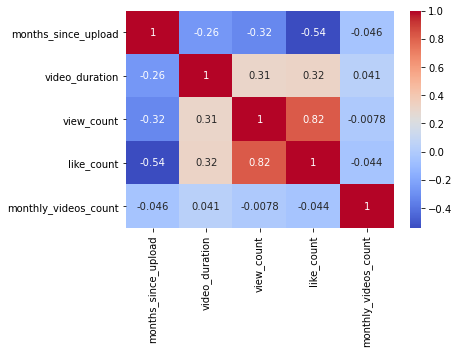

In [11]:
sns.heatmap(df1.corr(), annot = True, cmap = 'coolwarm')

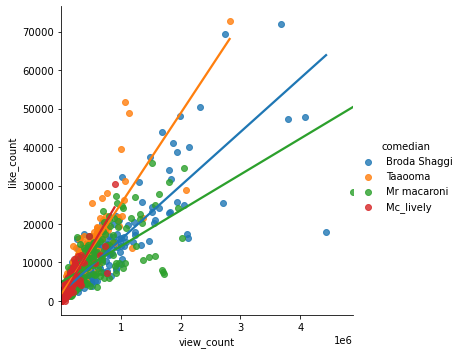

In [12]:
sns.lmplot(data = df1, x = 'view_count', y = 'like_count', hue = 'comedian', ci = None)

### Regression model of Likes and Views

In [13]:
from statsmodels.formula.api import ols

In [14]:
mdl_likes_vs_views = ols('like_count ~ comedian:view_count +\
                         year:view_count + 0', data = df1).fit()

#### Ten Videos with the most influence on regression model

In [15]:
df2 = df.copy()

In [16]:
summary_model = mdl_likes_vs_views.get_influence().summary_frame()

df2['leverage'] = summary_model['hat_diag']
df2['cooks_dist'] = summary_model['cooks_d']

most_influential = df2.sort_values(by = 'cooks_dist', ascending = False).head(10)
most_influential

,video_id,comedian,year,year_month,months_since_upload,video_duration,view_count,like_count,day_of_week,weekend_weekday,monthly_videos_count,gender,leverage,cooks_dist
611,Fu5IMZeGwJM,Broda Shaggi,2020,2020-07,21,2,4429850,17907,Tuesday,Weekday,10,M,0.143768,3.495256
1280,tc8flAoNwy8,Mr macaroni,2020,2020-02,26,2,4871728,28300,Saturday,Weekend,11,M,0.250993,3.081020
1129,qF_EEMt1I_g,Broda Shaggi,2020,2020-06,22,14,3685250,71996,Sunday,Weekend,10,M,0.099499,0.406470
308,aEm7Q0TVXYk,Taaooma,2020,2020-12,16,19,2089544,28876,Monday,Weekday,13,F,0.073761,0.359736
1076,p2w4sijMjdw,Broda Shaggi,2021,2021-02,14,31,2056523,25008,Monday,Weekday,8,M,0.044925,0.174893
325,aNvZZAKZtK4,Mc_lively,2018,2018-12,40,1,771594,7306,Saturday,Weekend,13,M,0.134871,0.149513
985,NdeHE1nQBf8,Mr macaroni,2021,2021-01,15,57,1568727,11783,Friday,Weekday,13,M,0.032686,0.104223
1335,uk-kETgWTI8,Mc_lively,2021,2021-09,7,6,738336,14176,Monday,Weekday,10,M,0.073919,0.097032
268,8wBBo4jaW70,Taaooma,2020,2020-10,18,15,1143639,48889,Friday,Weekday,8,F,0.022095,0.089679
673,H4IeC_8TbFY,Broda Shaggi,2020,2020-09,19,1,2705540,25578,Tuesday,Weekday,9,M,0.053628,0.087840


#### Slope coefficient of likes vs views

In [17]:
print(mdl_likes_vs_views.params)

comedian[Broda Shaggi]:view_count    0.012782
comedian[Mc_lively]:view_count       0.025398
comedian[Mr macaroni]:view_count     0.010112
comedian[Taaooma]:view_count         0.022837
year[T.2017]:view_count             -0.007436
year[T.2018]:view_count             -0.003288
year[T.2019]:view_count             -0.001237
year[T.2020]:view_count              0.001465
year[T.2021]:view_count              0.009190
dtype: float64


#### Regression Model Performance metrics (R-squared & RMSE)

In [18]:
print(mdl_likes_vs_views.rsquared)

0.8859361852250182


In [19]:
np.sqrt(mdl_likes_vs_views.mse_resid)

3569.4020849388944

## PREDICTIONS

In [20]:
df.head(3)

,video_id,comedian,year,year_month,months_since_upload,video_duration,view_count,like_count,day_of_week,weekend_weekday,monthly_videos_count,gender
0,-_lBNFG22e8,Broda Shaggi,2021,2021-01,15,5,607779,15480,Monday,Weekday,6,M
1,-25l5LMLddY,Broda Shaggi,2018,2018-05,47,1,278594,3574,Saturday,Weekend,17,M
2,-4RSFPC-fJo,Broda Shaggi,2018,2018-05,47,1,84598,1163,Thursday,Weekday,17,M


#### Add gender column to dataframe

In [21]:
comedian = df['comedian'].unique()

gender = ['M', 'F', 'M', 'M']

df['gender'] = df['comedian'].map(dict(zip(comedian, gender)))


### Data Preprocessing for modeling

In [22]:
new_df = df[['comedian', 'gender', 'year', 'months_since_upload', 'video_duration',
       'view_count', 'weekend_weekday', 'monthly_videos_count','like_count']]

In [23]:
new_df.head(2)

,comedian,gender,year,months_since_upload,video_duration,view_count,weekend_weekday,monthly_videos_count,like_count
0,Broda Shaggi,M,2021,15,5,607779,Weekday,6,15480
1,Broda Shaggi,M,2018,47,1,278594,Weekend,17,3574


In [24]:
new_df = pd.get_dummies(new_df, columns = ['comedian', 'gender', 'year','weekend_weekday']) 

In [25]:
X_new =new_df.columns.drop('like_count')
X = new_df[list(X_new)]
y = new_df['like_count']

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [27]:
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= SEED)

### Tree Model

In [28]:
def random_forest_model():
    rf = RandomForestRegressor(random_state= SEED)

    params_grid = {'n_estimators': np.arange(200, 250, 10),
            'min_samples_leaf': np.arange(0, 0.01, 0.001)}

    search = RandomizedSearchCV(estimator = rf, param_distributions= params_grid, cv = 5, scoring = 'neg_mean_absolute_error',
                     n_iter = 20, verbose = 0, n_jobs = -1)

    result = search.fit(X_train, y_train)

    best_hyperparams = result.best_params_
    best_score = result.best_score_

    best_model = result.best_estimator_
    print(f"Best hyperparams: {best_hyperparams} \nBest score: {best_score}")
    return best_model

In [29]:
model = random_forest_model()

C:\Users\tuneG\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [           nan -1509.93410107 -1430.71627268 -1451.55963657
 -1454.99350418 -1511.57935889 -1510.15334882 -1488.70463997
 -1451.10890037 -1471.25328105            nan -1429.12793397
 -1423.60197541 -1510.09221302 -1532.30629463 -1509.36297562
 -1416.62231015 -1424.32008549 -1421.73894173 -1430.55845023]
  warnings.warn(


Best hyperparams: {'n_estimators': 230, 'min_samples_leaf': 0.001} 
Best score: -1416.6223101481075


#### Mean Absolute Error of Random Forest model

In [30]:
y_pred = model.predict(X_test)
mae_test = MAE(y_test, y_pred)
print(mae_test)

1187.273198908448


#### Comparing Random Forest Model predictions to original values

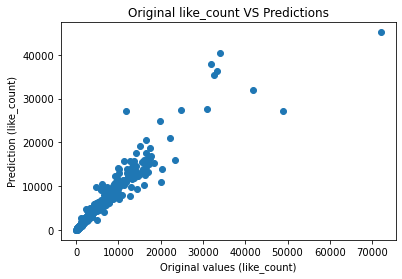

In [31]:
plt.scatter(x = y_test, y = y_pred)
plt.xlabel('Original values (like_count)')
plt.ylabel('Prediction (like_count)')
plt.title('Original like_count VS Predictions')
plt.show()

#### Model features importance

In [32]:
feature_scores = dict(zip(X_train.columns, model.feature_importances_))
list_of_tups = sorted(feature_scores.items(), key = lambda tup: tup[1], reverse = True)

def mult_tup(tu):
        return tu[0], round(tu[1]*100, 3)

yy = [mult_tup(tuppp) for tuppp in list_of_tups]

per_df =  pd.DataFrame.from_records(yy, columns =['Features', 'Importance Percentage %'])

per_df

,Features,Importance Percentage %
0,view_count,81.534
1,months_since_upload,10.500
2,video_duration,3.616
3,monthly_videos_count,1.929
4,comedian_Mr macaroni,0.525
5,gender_F,0.332
6,comedian_Taaooma,0.330
7,gender_M,0.325
8,comedian_Broda Shaggi,0.214
9,year_2020,0.169
